# Twitter Sentiment Analysis

In [31]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [32]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sm185567\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [33]:
# DATASET
DATASET_COLUMNS = ["Tweets"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 30

# SENTIMENT

SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [34]:

df = pd.read_csv(r'supervised_dataset.csv',low_memory=False)


In [35]:
print("Dataset size:", len(df))

Dataset size: 78639


In [36]:
df = df[['Tweets','compare']]

In [37]:
df = df.rename(columns={'compare': 'target','Tweets':'text'})

In [38]:
filtered_df = df[df['target'].isnull()==False]

In [39]:
filtered_df

,text,target
8,#Mirzapur2 fabulous series,Positive
15,When someone trying to give me spoiler,Neutral
26,RT @ihansika: I AM LOVING #Mirzapur2 ! It’s f...,Positive
28,@curiousvelocite @GabbbarSingh Will there be #...,Neutral
34,RT @y2jbaybay: Whenever someone asks me about ...,Neutral
...,...,...
78449,What if Mirzapur 2 again ends with suspense?,Neutral
78457,October 23rd #Mirzapur2 let's binge watch it t...,Neutral
78482,16 October 2004 When @TripathiiPankaj came to ...,Neutral
78501,excited to witness the magic of super talented...,Positive


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

In [102]:
target_cnt = Counter(filtered_df.target)
target_cnt.keys(),target_cnt.values()

(dict_keys(['Positive', 'Neutral', 'Negative']),
 dict_values([1109, 2125, 887]))

Text(0.5, 1.0, 'Dataset labels distribuition')

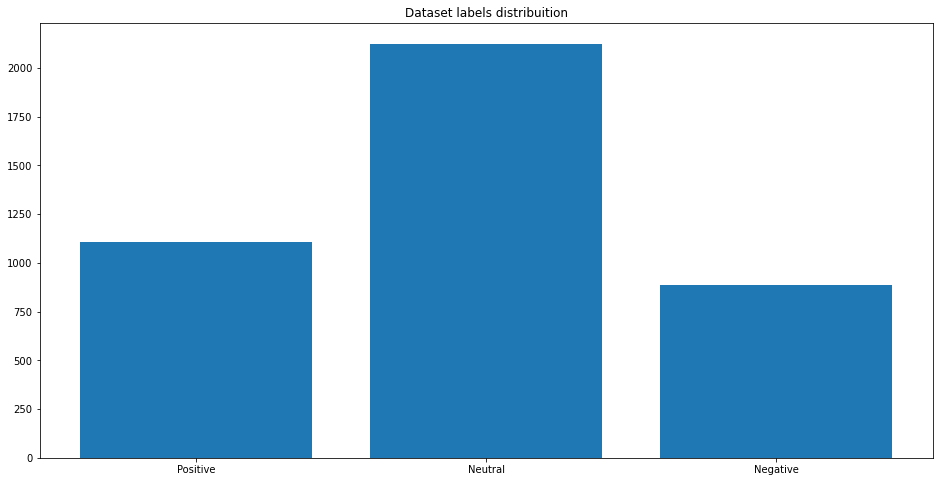

In [103]:
target_cnt = Counter(filtered_df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [104]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [44]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [45]:
%%time
filtered_df['text'] = filtered_df.text.apply(lambda x: preprocess(x))


hi
Wall time: 99 ms


C:\Users\sm185567\AppData\Local\Continuum\anaconda3\envs\gpu-user\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Split train and test

In [46]:
df_train, df_test = train_test_split(filtered_df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 3296
TEST size: 825


### Word2Vec 

In [47]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 3 ms


In [48]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [49]:
w2v_model.build_vocab(documents)

2020-11-23 22:16:41,320 : INFO : collecting all words and their counts
2020-11-23 22:16:41,321 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-11-23 22:16:41,327 : INFO : collected 2761 word types from a corpus of 23428 raw words and 3296 sentences
2020-11-23 22:16:41,328 : INFO : Loading a fresh vocabulary
2020-11-23 22:16:41,330 : INFO : effective_min_count=10 retains 322 unique words (11% of original 2761, drops 2439)
2020-11-23 22:16:41,331 : INFO : effective_min_count=10 leaves 18300 word corpus (78% of original 23428, drops 5128)
2020-11-23 22:16:41,332 : INFO : deleting the raw counts dictionary of 2761 items
2020-11-23 22:16:41,333 : INFO : sample=0.001 downsamples 72 most-common words
2020-11-23 22:16:41,334 : INFO : downsampling leaves estimated 9996 word corpus (54.6% of prior 18300)
2020-11-23 22:16:41,335 : INFO : estimated required memory for 322 words and 300 dimensions: 933800 bytes
2020-11-23 22:16:41,336 : INFO : resetting layer weights

In [50]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 322


In [51]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-11-23 22:16:42,022 : INFO : training model with 8 workers on 322 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-11-23 22:16:42,034 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-11-23 22:16:42,037 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-11-23 22:16:42,038 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-11-23 22:16:42,039 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-11-23 22:16:42,039 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-23 22:16:42,040 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-23 22:16:42,041 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-23 22:16:42,045 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-23 22:16:42,046 : INFO : EPOCH - 1 : training on 23428 raw words (9891 effective words) took 0.0s, 815948 effective 

2020-11-23 22:16:42,251 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-23 22:16:42,251 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-23 22:16:42,252 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-23 22:16:42,253 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-23 22:16:42,254 : INFO : EPOCH - 10 : training on 23428 raw words (10005 effective words) took 0.0s, 831512 effective words/s
2020-11-23 22:16:42,268 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-11-23 22:16:42,272 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-11-23 22:16:42,273 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-11-23 22:16:42,274 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-11-23 22:16:42,275 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-23 22:16:42,276 : INFO : worker thread 

2020-11-23 22:16:42,490 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-11-23 22:16:42,491 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-11-23 22:16:42,492 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-11-23 22:16:42,495 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-11-23 22:16:42,496 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-23 22:16:42,496 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-23 22:16:42,497 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-23 22:16:42,498 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-23 22:16:42,499 : INFO : EPOCH - 20 : training on 23428 raw words (10010 effective words) took 0.0s, 722535 effective words/s
2020-11-23 22:16:42,512 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-11-23 22:16:42,514 : INFO : worker thread 

2020-11-23 22:16:42,691 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-23 22:16:42,694 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-23 22:16:42,694 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-23 22:16:42,695 : INFO : EPOCH - 29 : training on 23428 raw words (9983 effective words) took 0.0s, 691664 effective words/s
2020-11-23 22:16:42,705 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-11-23 22:16:42,709 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-11-23 22:16:42,711 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-11-23 22:16:42,713 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-11-23 22:16:42,714 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-23 22:16:42,715 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-23 22:16:42,715 : INFO : worker thread f

Wall time: 743 ms


(319583, 749696)

In [52]:
w2v_model.most_similar("mirzapur")

C:\Users\sm185567\AppData\Local\Continuum\anaconda3\envs\gpu-user\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-11-23 22:16:42,771 : INFO : precomputing L2-norms of word weight vectors


[('2', 0.9340503215789795),
 ('season', 0.9298324584960938),
 ('released', 0.8415657877922058),
 ('1', 0.8405765295028687),
 ('mi', 0.8402047157287598),
 ('fans', 0.811823844909668),
 ('characters', 0.7961575984954834),
 ('3', 0.7910913825035095),
 ('sleep', 0.7815923094749451),
 ('entire', 0.7780166864395142)]

### Tokenize Text

In [53]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 2762
Wall time: 36 ms


In [54]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 52.1 ms


### Label Encoder 

In [55]:
labels = df_train.target.unique().tolist()

labels

['Negative', 'Positive', 'Neutral']

In [56]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (3296, 1)
y_test (825, 1)


In [57]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (3296, 300)
y_train (3296, 1)

x_test (825, 300)
y_test (825, 1)


In [58]:
y_train[:10]

array([[0],
       [0],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2]], dtype=int64)

### Embedding layer

In [59]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(2762, 300)


In [60]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [61]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2020-11-23 22:16:52,427 : WARNING : Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          828600    
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 989,101
Trainable params: 160,501
Non-trainable params: 828,600
_________________________________________________________________


### Compile model

In [62]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [63]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [64]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
99/99 [==============================] - ETA: 0s - loss: -3.3006 - accuracy: 0.6763WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-11-23 22:18:58,676 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


99/99 [==============================] - 123s 1s/step - loss: -3.3006 - accuracy: 0.6763 - val_loss: -4.7845 - val_accuracy: 0.6788
Epoch 2/8
99/99 [==============================] - ETA: 0s - loss: -6.6308 - accuracy: 0.6885WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-11-23 22:21:54,081 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


99/99 [==============================] - 174s 2s/step - loss: -6.6308 - accuracy: 0.6885 - val_loss: -7.5115 - val_accuracy: 0.6970
Epoch 3/8
99/99 [==============================] - ETA: 0s - loss: -9.1483 - accuracy: 0.6932WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-11-23 22:24:55,843 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


99/99 [==============================] - 180s 2s/step - loss: -9.1483 - accuracy: 0.6932 - val_loss: -9.7728 - val_accuracy: 0.6970
Epoch 4/8
99/99 [==============================] - ETA: 0s - loss: -11.4713 - accuracy: 0.6922WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-11-23 22:27:05,198 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


99/99 [==============================] - 127s 1s/step - loss: -11.4713 - accuracy: 0.6922 - val_loss: -11.9229 - val_accuracy: 0.6970
Epoch 5/8
99/99 [==============================] - ETA: 0s - loss: -13.7826 - accuracy: 0.6935WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-11-23 22:28:53,099 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


99/99 [==============================] - 107s 1s/step - loss: -13.7826 - accuracy: 0.6935 - val_loss: -14.1607 - val_accuracy: 0.6970
Epoch 6/8
99/99 [==============================] - ETA: 0s - loss: -16.0795 - accuracy: 0.6935WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-11-23 22:30:36,456 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


99/99 [==============================] - 102s 1s/step - loss: -16.0795 - accuracy: 0.6935 - val_loss: -16.3064 - val_accuracy: 0.6970
Epoch 7/8
99/99 [==============================] - ETA: 0s - loss: -18.3411 - accuracy: 0.6929WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-11-23 22:32:17,811 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


99/99 [==============================] - 100s 1s/step - loss: -18.3411 - accuracy: 0.6929 - val_loss: -18.4646 - val_accuracy: 0.6970
Epoch 8/8
99/99 [==============================] - ETA: 0s - loss: -20.6066 - accuracy: 0.6935WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-11-23 22:34:01,324 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


99/99 [==============================] - 102s 1s/step - loss: -20.6066 - accuracy: 0.6935 - val_loss: -20.5455 - val_accuracy: 0.6970
Wall time: 17min 8s


### Evaluate

In [65]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

28/28 [==============================] - 2s 65ms/step - loss: -19.8799 - accuracy: 0.6933

ACCURACY: 0.6933333277702332
LOSS: -19.87989616394043
Wall time: 3.56 s


In [72]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


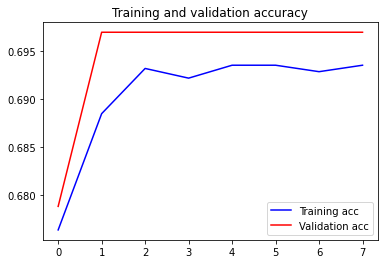

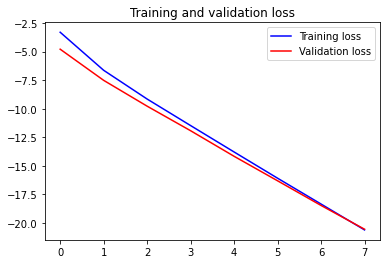

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [86]:
def decode_sentiment(score, include_neutral=True ):
    if include_neutral:        
        label = "Neutral"
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = "Negative"
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = "Positive"

        return label
    else:
        return "Negative" if score < 0.5 else "Positive"

In [87]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [88]:
predict("I love the music")

{'label': 'Positive', 'score': 1.0, 'elapsed_time': 1.3277308940887451}

In [89]:
predict("mirzapur is worst series i have ever seen")

{'label': 'Positive', 'score': 1.0, 'elapsed_time': 0.09399867057800293}

In [90]:
predict("i don't know what i'm doing")

{'label': 'Positive', 'score': 1.0, 'elapsed_time': 0.09399843215942383}

### Confusion Matrix

In [91]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

1/1 [==============================] - 0s 140ms/step
Wall time: 433 ms


In [92]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

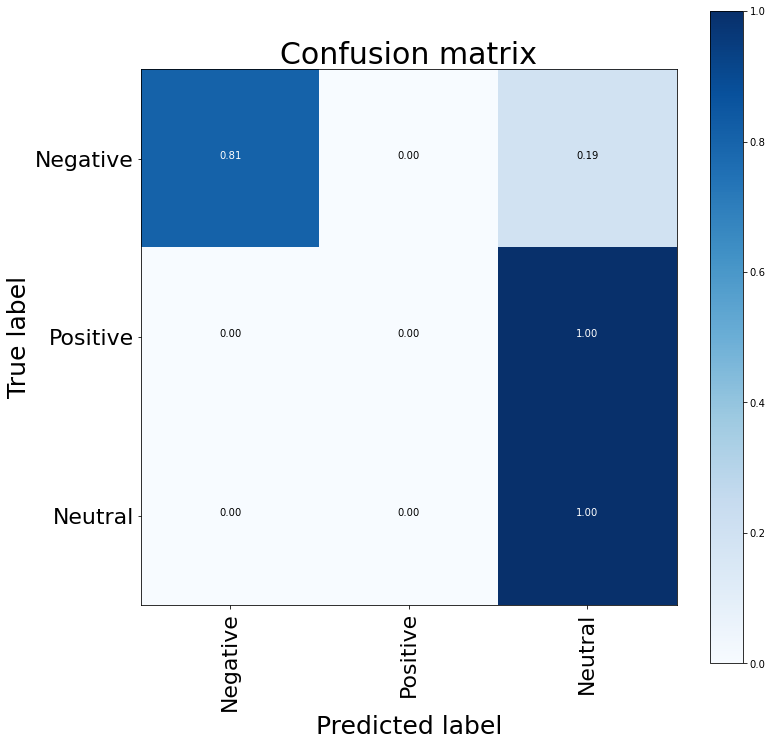

Wall time: 218 ms


In [93]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [94]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    Negative       1.00      0.81      0.89       190
     Neutral       0.00      0.00      0.00       419
    Positive       0.32      1.00      0.49       216

    accuracy                           0.45       825
   macro avg       0.44      0.60      0.46       825
weighted avg       0.31      0.45      0.33       825



C:\Users\sm185567\AppData\Local\Continuum\anaconda3\envs\gpu-user\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Accuracy Score

In [95]:
accuracy_score(y_test_1d, y_pred_1d)

0.44727272727272727

In [101]:
for i,j in zip(y_test_1d,y_pred_1d):
    print(i,"=====>",j)

Positive =====> Positive
Neutral =====> Positive
Neutral =====> Positive
Positive =====> Positive
Positive =====> Positive
Negative =====> Positive
Negative =====> Negative
Neutral =====> Positive
Positive =====> Positive
Negative =====> Positive
Negative =====> Negative
Positive =====> Positive
Positive =====> Positive
Neutral =====> Positive
Neutral =====> Positive
Positive =====> Positive
Negative =====> Negative
Positive =====> Positive
Neutral =====> Positive
Neutral =====> Positive
Neutral =====> Positive
Neutral =====> Positive
Positive =====> Positive
Neutral =====> Positive
Negative =====> Negative
Neutral =====> Positive
Negative =====> Negative
Negative =====> Negative
Neutral =====> Positive
Negative =====> Negative
Positive =====> Positive
Neutral =====> Positive
Positive =====> Positive
Neutral =====> Positive
Negative =====> Negative
Positive =====> Positive
Neutral =====> Positive
Neutral =====> Positive
Neutral =====> Positive
Neutral =====> Positive
Neutral =====> Pos

### Save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)